In [1]:
"""
Time series prediction using LSTM in TensorFlow on 
monthly temperature average in England from 1723-1970.

Base code inspired by Hands-On ML with Scikit-learn and TensorFlow book.
Build on this by adding 
    -lstm using object oriented programming
    -additional RNN features
    -real data
    -multiple inputs
"""

import os
from datetime import datetime

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

# set graph size
plt.rcParams['figure.figsize'] = (10.0, 5.0)

DATA_FOLDER = 'data/'
FILE_NAME = 'monthly_temp_england.csv'
SAVE_PATH = 'saved/'

TRAIN_SPLIT = 0.7
# hyperparameters
N_STEPS = 20
N_INPUTS = 2
N_OUTPUTS = 1
N_NEURONS = 100
N_LAYERS = 1
BATCH_SIZE = 50
N_EPOCHS = 1000
KEEP_PROB = 0.5 # for dropout
LEARNING_RATE = 0.001

tf.reset_default_graph()

class LSTMModel(object):
    """Build an LSTM model for time series prediction"""
    def __init__(self, learning_rate, n_neurons, n_steps, n_inputs, 
                 n_outputs, n_layers, keep_prob, is_training):
        self.lr = learning_rate
        self.n_neurons = n_neurons
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = n_layers
        self.keep_prob = keep_prob
        self.is_training = is_training
             
    def _create_placeholders(self):
        """Create placeholders for inputs and outputs"""
        with tf.name_scope('data'):
            self.X = tf.placeholder(tf.float32, 
                                    [None, self.n_steps, self.n_inputs], 
                                    name='X')
            self.y = tf.placeholder(tf.float32, 
                                    [None, self.n_steps, self.n_outputs], 
                                    name='y')
            
    def _create_rnn(self):
        """Create lstm cell with dropout + multilayers"""
        with tf.name_scope('rnn'):
            rnn_cell = tf.contrib.rnn.BasicLSTMCell(num_units=self.n_neurons)
            if self.is_training: # only apply dropout during training
                rnn_cell = tf.contrib.rnn.DropoutWrapper(
                    rnn_cell, input_keep_prob=self.keep_prob)
            # create multiple layers
            multi_rnn_cell = tf.contrib.rnn.MultiRNNCell(
                [rnn_cell] * self.n_layers)
            rnn_outputs, states = tf.nn.dynamic_rnn(rnn_cell, 
                                                    self.X, dtype=tf.float32)
            
            # two options: 1. apply OutputProjection to rnn_cell 2. the code below
            # 2. is faster as there is only one fully connected layer instead of 
            # one per time step
            stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, self.n_neurons])
            stacked_outputs = tf.layers.dense(stacked_rnn_outputs, self.n_outputs)
            self.outputs = tf.reshape(stacked_outputs, 
                                      [-1, self.n_steps, self.n_outputs], 
                                      name='outputs')
     
    def _create_loss(self):
        """Create MSE loss function"""
        with tf.name_scope('loss'):
            self.loss = tf.reduce_sum(tf.square(self.outputs - self.y), 
                                      name='loss')
            
    def _create_optimizer(self):
        """Define optimizer and training op to minimize loss."""
        with tf.name_scope('optimize'):
            optimizer = tf.train.AdamOptimizer(self.lr)
            self.train_op = optimizer.minimize(self.loss)
            
    def build_model(self):
        """Build model with all components"""
        self._create_placeholders()
        self._create_rnn()
        self._create_loss()
        self._create_optimizer()
        self.init = tf.global_variables_initializer()

        
def load_data():
    """Load data into pandas DataFrame"""
    csv_path = os.path.join(DATA_FOLDER, FILE_NAME)
    return pd.read_csv(csv_path)


def train_test_split(data, split):
    """Split data into train and test sets."""
    train_size = int(data.shape[0] * split)
    train_data = data.loc[:train_size, :]
    test_data = data.loc[train_size:, :]
    return train_data, test_data


def data_prep(data, split=0.70):
    """Prepare data for model (split train/test and scale)."""
    # Add month column which will be input to model.
    month = data['year_month'].str.slice(-2,)
    data['month'] = month
    
    # split into train/test datasets
    train_data, test_data = train_test_split(data, split)
    
    # Scale data so inputs have similar level
    minmax_scaler = MinMaxScaler().fit(train_data[['monthly_temp', 'month']])
    for df in [train_data, test_data]:
        df[['monthly_temp', 'month']] = minmax_scaler.transform(
            df[['monthly_temp', 'month']])

    return train_data, test_data, minmax_scaler


def plot_data(df, size=240):
    """Plot raw data"""
    plt.plot(df['monthly_temp'][:size], 'b')
    plt.xlabel('Months since {0}'.format(df.iloc[0]['year_month']))
    plt.ylabel('Temperature - Celcius')
    plt.show()

    
def get_batch(data, model, batch_size):
    """Gets random batch from data."""
    index = np.random.randint(data.shape[0] - model.n_steps, 
                              size=(batch_size, 1))
    indices = index + np.arange(0, model.n_steps + 1)
    batch = data[input_columns].values[indices]
    if model.is_training:
        # return batch of x and y, with y being one timestep after each x
        return batch[:, :-1, :], batch[:, 1:, :1]
    else:
        # only return x when testing
        return batch

    
def plot_test_sequence(n_steps, test_sequence, y_seq):
    """Plot that includes actual, target, and predicted temperatures."""
    plt.title('Testing the model', fontsize=14)
    # plot actual (x) values
    plt.plot(np.arange(n_steps), test_sequence[:-1,0], 'bo', 
             markersize=10, label='instance')
    
    # plot target (y) values
    plt.plot(np.arange(1, n_steps+1), test_sequence[1:,0], 
             'w*', markersize=10, label='target')
    
    # plot predicted values from model
    plt.plot(np.arange(1, n_steps+1), y_seq[:,0], 
             'r.', markersize=10, label='prediction')
    
    plt.legend(loc='upper left')
    plt.xlabel('Time')
    plt.show()

    
def train_model(model, train_data, n_epochs, batch_size):
    """Train LSTM on time series data. 
    
    Output train/test MSE and save model after last epoch.
    """
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(model.init)
        for epoch in range(n_epochs):
            # get random batch
            X_batch, y_batch = get_batch(train_data, model, batch_size)
            _, train_mse = sess.run([model.train_op, model.loss], 
                                     feed_dict={model.X: X_batch, model.y: y_batch})
            
            if epoch % 100 == 0: # display loss every 100 epochs
                X_test, y_test = get_batch(test_data, model, batch_size)
                test_mse = sess.run(model.loss, 
                                    feed_dict={model.X: X_test, model.y: y_test})
                print('Epoch {0}, Train Mse: {1:.2f}, Test Mse: {2:.2f}'.format(
                    epoch, train_mse, test_mse))
        # save model
        saver.save(sess, SAVE_PATH)


def test_model(test_data, minmax_scaler, batch_size=1):
    """Get random sequence from test data and plot model predictions
    at each time step."""
    
    # create train saver and restore the model
    saver = tf.train.Saver()
    with tf.Session() as sess:
        print('Restoring model...')
        saver.restore(sess, SAVE_PATH)

        # set is_training to false which turns off dropout and gets batch for testing
        model.is_training = False
        test_sequence = get_batch(test_data, model, batch_size)
        X_seq = np.array(test_sequence[0,:-1,:].reshape(-1, model.n_steps, model.n_inputs))
        y_seq = sess.run(model.outputs, feed_dict={model.X: X_seq})
        
        # reshape and rescale for plotting
        test_sequence = test_sequence.reshape(-1, test_sequence.shape[2])
        test_sequence = minmax_scaler.inverse_transform(test_sequence)
        # add months column to y_seq
        y_seq = np.hstack((y_seq.reshape(-1,1), X_seq[:,:,1].reshape(-1,1)))
        y_seq = minmax_scaler.inverse_transform(y_seq)
        
        plot_test_sequence(model.n_steps, test_sequence, y_seq)

In [2]:
# instantiate LSTM model and build components
model = LSTMModel(LEARNING_RATE, N_NEURONS, N_STEPS, N_INPUTS, N_OUTPUTS, N_LAYERS, KEEP_PROB, is_training=True)
model.build_model()

# prep data for training
raw_data = load_data()
train_data, test_data, minmax_scaler = data_prep(raw_data, TRAIN_SPLIT)
input_columns = ['monthly_temp', 'month']
train_model(model, train_data, N_EPOCHS, BATCH_SIZE)

Epoch 0, Train Mse: 313.90, Test Mse: 262.05
Epoch 100, Train Mse: 43.58, Test Mse: 34.43
Epoch 200, Train Mse: 30.73, Test Mse: 30.16
Epoch 300, Train Mse: 23.61, Test Mse: 29.72
Epoch 400, Train Mse: 21.71, Test Mse: 21.38
Epoch 500, Train Mse: 21.31, Test Mse: 18.49
Epoch 600, Train Mse: 18.61, Test Mse: 16.59
Epoch 700, Train Mse: 18.17, Test Mse: 14.99
Epoch 800, Train Mse: 14.36, Test Mse: 14.73
Epoch 900, Train Mse: 13.10, Test Mse: 10.35


Restoring model...
INFO:tensorflow:Restoring parameters from saved/


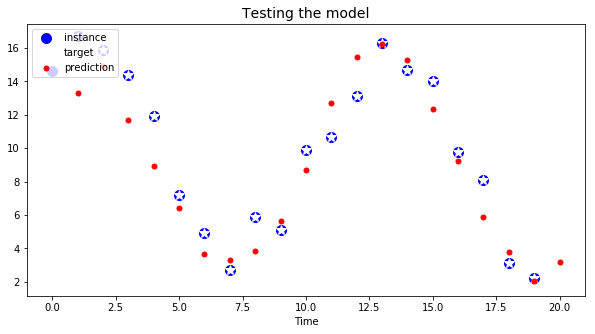

In [6]:
# restore model and use to predict values in sequence
test_model(test_data, minmax_scaler)